In [255]:
import time
import os
import sys
import operator
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
import multiprocessing as mp
from collections import Counter, defaultdict
import numpy as np
from fasta_parser import parse_fasta
from count_kmers import count_kmers
from sequence_utils import get_palindromes, get_all_possible_kmers
from system_utils import get_all_fasta

In [1]:
seqApprox = [
    'tagtggtcttttgagtgtagatctgaagggaaagtatttccaccagttcggggtcacccagcagggcagggtgacttaat',
    'cgcgactcggcgctcacagttatcgcacgtttagaccaaaacggagttggatccgaaactggagtttaatcggagtcctt',
    'gttacttgtgagcctggttagacccgaaatataattgttggctgcatagcggagctgacatacgagtaggggaaatgcgt',
    'aacatcaggctttgattaaacaatttaagcacgtaaatccgaattgacctgatgacaatacggaacatgccggctccggg',
    'accaccggataggctgcttattaggtccaaaaggtagtatcgtaataatggctcagccatgtcaatgtgcggcattccac',
    'tagattcgaatcgatcgtgtttctccctctgtgggttaacgaggggtccgaccttgctcgcatgtgccgaacttgtaccc',
    'gaaatggttcggtgcgatatcaggccgttctcttaacttggcggtgcagatccgaacgtctctggaggggtcgtgcgcta',
    'atgtatactagacattctaacgctcgcttattggcggagaccatttgctccactacaagaggctactgtgtagatccgta',
    'ttcttacacccttctttagatccaaacctgttggcgccatcttcttttcgagtccttgtacctccatttgctctgatgac',
    'ctacctatgtaaaacaacatctactaacgtagtccggtctttcctgatctgccctaacctacaggtcgatccgaaattcg']


In [ ]:
def Score(s, DNA, k):
    """ 
        compute the consensus SCORE of a given k-mer 
        alignment given offsets into each DNA string.
            s = list of starting indices, 1-based, 0 means ignore
            DNA = list of nucleotide strings
            k = Target Motif length
    """
    score = 0
    for i in xrange(k):
        # loop over string positions
        cnt = dict(zip("acgt",(0,0,0,0)))
        for j, sval in enumerate(s):
            # loop over DNA strands
            base = DNA[j][sval+i] 
            cnt[base] += 1
        score += max(cnt.itervalues())
    return score

In [ ]:
def motif_score()

In [12]:
def get_kmer_count(sequence, kmer_length, nprocs=None):
    """
    Counts the number of k-mers of a specified length in a given sequence
    :param sequence: string representation of a sequence
    :param kmer_length: desired length of k-mer
    :param nprocs: number of processors to use
    :return: collections.Counter (dictionary) object indexed by k-mer and mapped to number of occurences
    """
    start = time.time()
    if nprocs is None:
        nprocs = mp.cpu_count()
    args = split_seq(sequence, nprocs, overlap=kmer_length)
    args = [[seq, kmer_length] for seq in args]
    pool = mp.Pool(nprocs)
    results = [res.get() for res in [pool.starmap_async(kmer_search, args)]]
    pool.close()
    counts = Counter()
    for result in results[0]:
        for k, v in result.items():
            counts[k] += v
    # print("Done in " + str(time.time() - start))
    return counts

In [13]:
def generate_kmers(k):
    """Generates a list of all possible DNA sequences of length k. E.g. generate_kmers(2) will return
    [ AA, AC, AT, AG, CA, CC, CT, CG, TA, TC, TT, TG, GA, GC, GT, GG ] """
    len_k = int(k)
    if len_k < 0:
        raise ValueError("Must be a positive integer")
    combos = list(itertools.product('ACTG', repeat=len_k))
    seqs = []
    for seq in combos:
        seqs.append(''.join(seq))
    return seqs

In [18]:
def kmer_search(sequence, kmer_length, count_gc=False, count_n=False):
    """
    Driver for get_kmer_count
    :param sequence:
    :param kmer_length:
    :param count_gc: Return GC content (default = False)
    :param count_n: Reurn count number of unreferenced nucleotides (default = False)
    :return:
    """
    counts = Counter()
    for i in range(len(sequence) - (kmer_length - 1)):  # This takes the (1-based) reference sequence for chromosome 22
        next_seq = sequence[i:(i + kmer_length)]
        if not ('N' in next_seq or 'n' in next_seq):
            counts[next_seq.upper()] += 1
    if count_gc and count_n:
        nucleotides = Counter(sequence)
        gc_content = (nucleotides['G'] + nucleotides['C']) / max(
            (nucleotides['A'] + nucleotides['T'] + nucleotides['G'] + nucleotides['C']), 1)
        return counts, gc_content, nucleotides['N']
    elif count_gc and not count_n:
        nucleotides = Counter(sequence)
        gc_content = (nucleotides['G'] + nucleotides['C']) / max((
                nucleotides['A'] + nucleotides['T'] + nucleotides['G'] + nucleotides['C']), 1)
        return counts, gc_content
    elif not count_gc and count_n:
        nucleotides = Counter(sequence)
        return counts, nucleotides['N']
    else:
        return counts

In [14]:
def merge_transitions_ddc(dict_list, outfile=None):
    """
    Merge a list of defaultdict(Counter)'s into a single data structure
    :param outfile: name of file to write (leave empty or ignore to not write to disk)
    :param dict_list: type = iterable containing defaultdict(Counter)
    :return: a single defaultdict(Counter)
    """
    master_count = defaultdict(Counter)
    for counts in dict_list:
        for k, v in counts.items():
            for alt, count in v.items():
                master_count[k][alt] += count
    if outfile is not None and len(outfile) > 1:
        print('Writing kmer transitions to file %s' % outfile)
        pd.DataFrame.from_dict(master_count, orient='index').to_csv(outfile)
    return master_count

In [2]:
def split_seq(sequence, nprocs, overlap=None):
    """
    :param sequence: string sequence to split
    :param nprocs: number of CPUs to use
    :param overlap: for use when counting k-mers. If considering 3-mers, overlap=3
    :return: a list of 'nprocs' roughly equal chunks to pass as an argument to python multiprocessing
    """
    chunk_size = int(len(sequence) / nprocs) + 1
    args = []
    start = 0
    end = chunk_size
    for proc in range(nprocs):
        if overlap is not None:
            args.append(sequence[start:(end + overlap - 1)])
        else:
            args.append(sequence[start:end])
        start = end
        end += chunk_size
        if end > len(sequence):
            end = len(sequence)
    return args

In [4]:
for Id, seq in parse_fasta('Data/test/Influenzae/Chromosomes/H.influenzae.fa.gz'):
    seq_splt = split_seq(seq, 2, overlap=None)

In [6]:
len(seq_splt)

2

In [9]:
len(seq_splt[0]), len(seq_splt[1]), len(seq)

(915071, 915069, 1830140)

In [24]:
%time get_kmer_count(seq, 6, nprocs=2)

CPU times: user 10.1 ms, sys: 8.88 ms, total: 19 ms
Wall time: 336 ms


Counter({'TATGGC': 523,
         'ATGGCA': 908,
         'TGGCAA': 1157,
         'GGCAAT': 833,
         'GCAATT': 1196,
         'CAATTA': 1181,
         'AATTAA': 2178,
         'ATTAAA': 2294,
         'TTAAAA': 2378,
         'TAAAAT': 2243,
         'AAAATT': 3286,
         'AAATTG': 1975,
         'AATTGG': 1020,
         'ATTGGT': 1055,
         'TTGGTA': 804,
         'TGGTAT': 623,
         'GGTATC': 348,
         'GTATCA': 425,
         'TATCAA': 1256,
         'ATCAAT': 1568,
         'TCAATG': 921,
         'CAATGG': 893,
         'AATGGT': 954,
         'ATGGTT': 742,
         'TGGTTT': 1343,
         'GGTTTT': 1075,
         'GTTTTG': 995,
         'TTTTGG': 1189,
         'TTTGGT': 1105,
         'TTGGTC': 385,
         'TGGTCG': 335,
         'GGTCGT': 316,
         'GTCGTA': 257,
         'TCGTAT': 374,
         'CGTATC': 273,
         'GTATCG': 316,
         'TATCGG': 394,
         'ATCGGC': 360,
         'TCGGCC': 32,
         'CGGCCG': 32,
         'GGCCGT': 79,
  

In [77]:
def get_kmers_count(sequence, kmin, kmax, nprocs=None):
    """
    Counts the number of k-mers of a specified length in a given sequence
    :param sequence: string representation of a sequence
    :param kmer_length: desired length of k-mer
    :param nprocs: number of processors to use
    :return: collections.Counter (dictionary) object indexed by k-mer and mapped to number of occurences
    """
    start = time.time()
    if nprocs is None:
        nprocs = mp.cpu_count()
    args = split_seq(sequence, nprocs, overlap=None)
    args = [[seq, kmin, kmax] for seq in args]
    #func = partial(count_kmers, kmin, kmax)
    pool = mp.Pool(nprocs)
    results = [res.get() for res in [pool.starmap_async(count_kmers, args)]]
    pool.close()
    counts = Counter()
    for result in results[0]:
        for k, v in result.items():
            counts[k] += v
    end = time.time()
    print("Done countinh kmers in " + str(round(end - start, 4)))
    return counts

In [46]:
%time get_kmers_count(seq, 4, 6, nprocs=4)

CPU times: user 20.4 ms, sys: 24.4 ms, total: 44.8 ms
Wall time: 330 ms


Counter({'AAAA': 30845,
         'AAAC': 13059,
         'AAAG': 13972,
         'AAAT': 25038,
         'AACA': 11067,
         'AACC': 7617,
         'AACG': 7916,
         'AACT': 7905,
         'AAGA': 10396,
         'AAGC': 9459,
         'AAGG': 6482,
         'AAGT': 9989,
         'AATA': 17391,
         'AATC': 11948,
         'AATG': 13701,
         'AATT': 23070,
         'ACAA': 11397,
         'ACAC': 4465,
         'ACAG': 4792,
         'ACAT': 6578,
         'ACCA': 8475,
         'ACCC': 2971,
         'ACCG': 4851,
         'ACCT': 5156,
         'ACGA': 5925,
         'ACGC': 5680,
         'ACGG': 3821,
         'ACGT': 5657,
         'ACTA': 4636,
         'ACTC': 3227,
         'ACTG': 4768,
         'ACTT': 10002,
         'AGAA': 11760,
         'AGAC': 2364,
         'AGAG': 3405,
         'AGAT': 8186,
         'AGCA': 8546,
         'AGCC': 5373,
         'AGCG': 4678,
         'AGCT': 5638,
         'AGGA': 3791,
         'AGGC': 4581,
         'AGGG': 2554

In [48]:
330*28900

9537000

In [78]:
c = get_kmers_count(seq, 4, 6, nprocs=4)

Done countinh kmers in 0.3525


In [ ]:
len(kmer)

In [68]:
pal_list = list(get_palindromes('ACGT', 6, 6))

In [69]:
p = {}
for pal in pal_list:
    p[pal] = p.get(pal, 0) + c[pal]

In [73]:
len(p), len(pal_list)

(64, 64)

In [96]:
fasta_dict = get_all_fasta('Data/test', 'Chromosomes', 'gz')

In [97]:
fasta_dict

defaultdict(list,
            {'Acidiphilium': ['Data/test/Acidiphilium/Chromosomes/GCF_000016725.1_chr.fna.gz',
              'Data/test/Acidiphilium/Chromosomes/GCF_000202835.1_chr.fna.gz']})

In [103]:
d2

{'Acidiphilium': ['Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000016725.1_chr.fna.gz, Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000202835.1_chr.fna.gz']}

In [87]:
def count_k_mers_fasta(fasta_dict, name, alphabet, kmin, kmax, nprocs=None):
    """
    Function to count all n-grams/k-mers (substrings of lenght n or k) in a
    big string/genome.

    Inputs:
        fasta_dict - a dictionary-like object that map a word/kmer to their value,
                    in this case a full path to the files to be analized.
        name - a string representing a word (key) that represent a key in a
               dictionary.
        kmin - a integer representing the lower bound of the kmer/n-gram length.
        kmax - a integer representing the maximum bound of the kmer/n-gram length.

    Outputs:
        final_counter - a dictionary-like mapping the kmers to their calculated count
                        in the input string, from a file.
        seq_length - a integer representing the mean of the lengths from all genomes
                     files in the directory.
    """
    # alphabet as a set
    alphabet = set(alphabet)
    # get the number of files in the names directory
    num_fastas = len(fasta_dict[name])
    print(f'The number of fasta files for this genus is {num_fastas}.')
    # initialyze the counter
    counter = Counter()
    # get the sequence length
    seq_len = 0
    num_files = 0
    # iterates through the list of paths
    for filename in fasta_dict[name]:
        # reads the file and parse the content
        print(f'Reading and parsing the file {filename}')
        for name, sequence in parse_fasta(filename):
            print(f'Sequence length {len(sequence)}')
            seq_len += len(sequence)
            # get the counting the kmers
            cnt = get_kmers_count(sequence, kmin, kmax, nprocs)
            # add the count of the current file to the counter
            counter.update(cnt)
        num_files += 1
    # to get the mean of the kmer count for all the files
    final_counter = {k: (c // num_fastas) for k, c in counter.items() if set(k).issubset(alphabet)}
    # get mean of genomes lengths
    seq_length = int(seq_len / num_files)
    return final_counter, seq_length

In [84]:
di = {'influenza': ['Data/test/Influenzae/Chromosomes/H.influenzae.fa.gz']}

In [86]:
%time count_k_mers_fasta(di, 'influenza', 'ACGT', 4, 6, 4)

The number of fasta files for this genus is 1.
Reading and parsing the file Data/test/Influenzae/Chromosomes/H.influenzae.fa.gz
Sequence length 1830140
Done countinh kmers in 0.3239
CPU times: user 52.1 ms, sys: 34.1 ms, total: 86.2 ms
Wall time: 368 ms


{'AAAA': 30845,
 'AAAC': 13059,
 'AAAG': 13972,
 'AAAT': 25038,
 'AACA': 11067,
 'AACC': 7617,
 'AACG': 7916,
 'AACT': 7905,
 'AAGA': 10396,
 'AAGC': 9459,
 'AAGG': 6482,
 'AAGT': 9989,
 'AATA': 17391,
 'AATC': 11948,
 'AATG': 13701,
 'AATT': 23070,
 'ACAA': 11397,
 'ACAC': 4465,
 'ACAG': 4792,
 'ACAT': 6578,
 'ACCA': 8475,
 'ACCC': 2971,
 'ACCG': 4851,
 'ACCT': 5156,
 'ACGA': 5925,
 'ACGC': 5680,
 'ACGG': 3821,
 'ACGT': 5657,
 'ACTA': 4636,
 'ACTC': 3227,
 'ACTG': 4768,
 'ACTT': 10002,
 'AGAA': 11760,
 'AGAC': 2364,
 'AGAG': 3405,
 'AGAT': 8186,
 'AGCA': 8546,
 'AGCC': 5373,
 'AGCG': 4678,
 'AGCT': 5638,
 'AGGA': 3791,
 'AGGC': 4581,
 'AGGG': 2554,
 'AGGT': 5140,
 'AGTA': 5664,
 'AGTC': 2766,
 'AGTG': 6168,
 'AGTT': 7824,
 'ATAA': 15998,
 'ATAC': 6241,
 'ATAG': 5051,
 'ATAT': 11275,
 'ATCA': 12103,
 'ATCC': 5925,
 'ATCG': 6785,
 'ATCT': 8135,
 'ATGA': 8837,
 'ATGC': 7524,
 'ATGG': 7296,
 'ATGT': 6492,
 'ATTA': 16302,
 'ATTC': 10040,
 'ATTG': 13935,
 'ATTT': 24890,
 'CAAA': 15888,
 'CA

In [111]:
counts, seq_len = count_k_mers_fasta(di, 'influenza', 'ACGT', 6, 6, 4)

The number of fasta files for this genus is 1.
Reading and parsing the file Data/test/Influenzae/Chromosomes/H.influenzae.fa.gz


FileNotFoundError: [Errno 2] No such file or directory: 'Data/test/Influenzae/Chromosomes/H.influenzae.fa.gz'

In [104]:
d2 = {'Acidiphilium': ['Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000016725.1_chr.fna.gz', 'Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000202835.1_chr.fna.gz']}

In [98]:
counts1, seq_len1 = count_k_mers_fasta(fasta_dict, 'Acidiphilium', 'ACGT', 4, 6, 4)

The number of fasta files for this genus is 2.
Reading and parsing the file Data/test/Acidiphilium/Chromosomes/GCF_000016725.1_chr.fna.gz
Sequence length 3389227
Done countinh kmers in 0.5317
Reading and parsing the file Data/test/Acidiphilium/Chromosomes/GCF_000202835.1_chr.fna.gz
Sequence length 3749411
Done countinh kmers in 0.6202


In [100]:
seq_len1, 3389227+3749411, (3389227+3749411)//2

(3569319, 7138638, 3569319)

In [128]:
k_l = get_all_possible_kmers('ACGT', 6, 6)

In [113]:
ca = count_k_mers_fasta(d2, 'Acidiphilium', 'ACGT', 6, 6, 4)

The number of fasta files for this genus is 2.
Reading and parsing the file Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000016725.1_chr.fna.gz
Sequence length 3389227
Done countinh kmers in 0.2148
Reading and parsing the file Data/Genomes_splitted/Acidiphilium/Chromosomes/GCF_000202835.1_chr.fna.gz
Sequence length 3749411
Done countinh kmers in 0.2673


In [130]:
f = {}
for km in k_l:
    f[km] = f.get(km, 0) + ca[0][km]

In [124]:
def kmer_histogram(kmer_counts, k, max_counts):
    h = [0 for i in range(max_counts)]
    for kmer in kmer_counts:
        count = kmer_counts[kmer]
        if count < max_counts:
            h[count] += 1
    fig = plt.figure(figsize=(10, 6))
    plt.plot([i for i in range(max_counts)], h)
    plt.show();

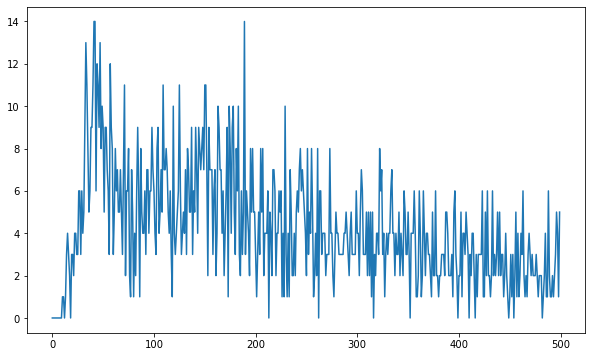

In [144]:
kmer_histogram(f, 6, 500)

In [143]:
max(f.items(), key=operator.itemgetter(1))[0]

'CGCCGC'

In [145]:
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    d = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            d += 1
    return d

In [147]:
hamming_distance('CGCCGC', 'CGTGGC')

2

In [157]:
ScanAndScoreMotif(seqApprox, "tagatccgaa")

([17, 47, 18, 33, 21, 0, 46, 70, 16, 65], 11)

In [181]:
def score_motif(sequences, pattern):
    total_distance = 0
    best_align = []
    k = len(pattern)
    for sequence in sequences:
        t = len(sequence)
        min_dist = k + 1
        for j in range(t - k + 1):
            hd = sum([1 for i in range(k) if pattern[i] != sequence[j+i]])
            if hd < min_dist:
                best = j
                min_dist = hd
        best_align.append(best)
        total_distance += min_dist
    return total_distance, best_align

In [182]:
score_motif(seqApprox, "tagatccgaa")

(11, [17, 47, 18, 33, 21, 0, 46, 70, 16, 65])

In [194]:
def MedianStringMotifSearch(DNA,k):
    """ Consider all possible 4**k motifs"""
    bestAlignment = []
    minHammingDist = k*len(DNA)
    kmer = ''
    for pattern in product('acgt', repeat=k):
        motif = ''.join(pattern)
        align, dist = ScanAndScoreMotif(DNA, motif)
        if (dist < minHammingDist):
            bestAlignment = [p for p in align]
            minHammingDist = dist
            kmer = motif
    return bestAlignment, minHammingDist, kmer

In [195]:
MedianStringMotifSearch(seqApprox,10)

KeyboardInterrupt: 

In [190]:
def median_string_motif_search(sequences, alphabet, k):
    best_a = []
    min_dist = k * len(sequences)
    kmer = []
    for prod in product(alphabet, repeat=k):
        motif = ''.join(prod)
        dist, idx = score_motif(sequences, motif)
        if dist < min_dist:
            best_a = [i for i in idx]
            min_dist = dist
            kmer.append(motif)
    return best_a, min_dist, kmer

In [191]:
median_string_motif_search(seqApprox, 'ACGT', 10)

KeyboardInterrupt: 

In [207]:
def count_base_position_motifs(motifs, alphabet):
    """
    Function to count of the nucleotides that appears in each
    position of the motifs alignment. 
    
    Inputs:
        motifs - a matrix-like objects of strings (list of lists)
        alphabet - a set of allowed charcaters that represent the sequence/string alphabet.
    
    Outputs:
        count - a dictionary-like object mapping the bases of the alphabet to the count
                of the number of times a base is found in position j (column) in the motifs
                matrix.
    Ex:
    
    m = ['AACGTA', 'CCCGTT', 'CACCTT', 'GGATTA', 'TTCCGG']
    count_base_position_motifs(m, 'ACGT')
    {'A': array([1., 2., 1., 0., 0., 2.]),
     'C': array([2., 1., 4., 2., 0., 0.]),
     'G': array([1., 1., 0., 2., 1., 1.]),
     'T': array([1., 1., 0., 1., 4., 2.])})    
    """
    k = len(motifs[0])
    assert all(len(m) == k for m in motifs), print('The motifs must have the same length')
    # initialize the counter
    count = defaultdict(int)
    # iterates through alphabet bases
    for base in alphabet:
        # create the empty array
        count[base] = count.get(base, np.zeros(len(motifs[0])))
    # iterates through all motifs
    for i, motif in enumerate(motifs):
        # iterates through bases in the mptifs
        for j, base in enumerate(motifs[0]):
            # motifs[i] base[j]
            base = motifs[i][j]
            # add to the count the base in
            # the position j in the cols
            count[base][j] += 1
    return count

In [210]:
# defaultdict(int,
#             {'A': [1, 2, 1, 0, 0, 2],
#              'C': [2, 1, 4, 2, 0, 0],
#              'G': [1, 1, 0, 2, 1, 1],
#              'T': [1, 1, 0, 1, 4, 2]})

m = ['AACGTA', 'CCCGTT', 'CACCTT', 'GGATTA', 'TTCCGG']
count_base_position_motifs(m, 'ACGT')

defaultdict(int,
            {'A': array([1., 2., 1., 0., 0., 2.]),
             'C': array([2., 1., 4., 2., 0., 0.]),
             'G': array([1., 1., 0., 2., 1., 1.]),
             'T': array([1., 1., 0., 1., 4., 2.])})

In [203]:
m1 = ['GTACAACTGT', 'CAACTATGAA', 'TCCTACAGGA', 'AAGCAAGGGT', 'GCGTACGACC',
      'TCGTCAGCGT', 'AACAAGGTCA', 'CTCAGGCGTC', 'GGATCCAGGT', 'GGCAAGTACC']

# defaultdict(int,
#             {'A': [2, 3, 3, 3, 6, 4, 2, 2, 1, 3],
#              'C': [2, 3, 4, 3, 2, 3, 2, 1, 3, 3],
#              'G': [4, 2, 3, 0, 1, 3, 4, 5, 5, 0],
#              'T': [2, 2, 0, 4, 1, 0, 2, 2, 1, 4]})

In [204]:
count_base_position_motifs(m1, 'ACGT')

defaultdict(int,
            {'A': array([2., 3., 3., 3., 6., 4., 2., 2., 1., 3.]),
             'C': array([2., 3., 4., 3., 2., 3., 2., 1., 3., 3.]),
             'G': array([4., 2., 3., 0., 1., 3., 4., 5., 5., 0.]),
             'T': array([2., 2., 0., 4., 1., 0., 2., 2., 1., 4.])})

In [215]:
def profile_motifs(motifs, alphabet):
    """
    Function that calculates the frequency of the base[i] in the counts array.
    
    Inputs:
        motifs - a list/array-like object representing a list of list of strings
                 that represent dna sequences to count the bases and it frequencies.
        alphabet - a set of allowed charcaters that represent the sequence/string alphabet.
    
    Outputs:
        dictionary - like object mapping the bases/charcaters that are found in each motif
                     positions.
    Ex:
    
    m = ['AACGTA', 'CCCGTT', 'CACCTT', 'GGATTA', 'TTCCGG']
    profile_motifs(m, 'ACGT')
    {'A': [0.2, 0.4, 0.2, 0.0, 0.0, 0.4],
     'C': [0.4, 0.2, 0.8, 0.4, 0.0, 0.0],
     'G': [0.2, 0.2, 0.0, 0.4, 0.2, 0.2],
     'T': [0.2, 0.2, 0.0, 0.2, 0.8, 0.4]}
    """
    # get the motif length
    k = len(motifs[0])
    # get the number of motifs
    t = len(motifs)
    # assert that all motifs have the same length
    assert all(len(m) == k for m in motifs), print('The motifs must have the same length')
    # get the motif positions counts
    counts = count_base_position_motifs(motifs, alphabet)
    # get the frequency of bases at each motif position
    return {base: [(c/t) for c in counts[base]] for
           base in counts.keys()}

In [216]:
profile_motifs(m, 'ACGT')

{'A': [0.2, 0.4, 0.2, 0.0, 0.0, 0.4],
 'C': [0.4, 0.2, 0.8, 0.4, 0.0, 0.0],
 'G': [0.2, 0.2, 0.0, 0.4, 0.2, 0.2],
 'T': [0.2, 0.2, 0.0, 0.2, 0.8, 0.4]}

In [218]:
# {'A': [0.2, 0.3, 0.3, 0.3, 0.6, 0.4, 0.2, 0.2, 0.1, 0.3],
#  'C': [0.2, 0.3, 0.4, 0.3, 0.2, 0.3, 0.2, 0.1, 0.3, 0.3],
#  'G': [0.4, 0.2, 0.3, 0.0, 0.1, 0.3, 0.4, 0.5, 0.5, 0.0],
#  'T': [0.2, 0.2, 0.0, 0.4, 0.1, 0.0, 0.2, 0.2, 0.1, 0.4]}
profile_motifs(m1, 'ACGT')

{'A': [0.2, 0.3, 0.3, 0.3, 0.6, 0.4, 0.2, 0.2, 0.1, 0.3],
 'C': [0.2, 0.3, 0.4, 0.3, 0.2, 0.3, 0.2, 0.1, 0.3, 0.3],
 'G': [0.4, 0.2, 0.3, 0.0, 0.1, 0.3, 0.4, 0.5, 0.5, 0.0],
 'T': [0.2, 0.2, 0.0, 0.4, 0.1, 0.0, 0.2, 0.2, 0.1, 0.4]}

In [219]:
def consensus_sequence(motifs, alphabet):
    """
    Function to characterize the consensus sequence from a matrix of 
    motifs of k length.
    
    Inputs:
        motifs - a list/array-like object representing a list of list of strings
                 that represent dna sequences to count the bases and it frequencies.
        alphabet - a set of allowed charcaters that represent the sequence/string alphabet.
    
    Outputs:
        consensus - a string object representing the consensus sequence from a matrix of
                    strings representing the motifs. The consensus is a string where the bases
                    at each position are the most frequent base in the aligned motifs.
    Ex:
    m = ['AACGTA', 
         'CCCGTT', 
         'CACCTT', 
         'GGATTA', 
         'TTCCGG']
    consensus_sequence(m, 'ACGT')
         'CACCTA'    
    """
    # get the motif length
    k = len(motifs[0])
    # check if all motifs have the same length
    assert all(len(m) == k for m in motifs), print('The motifs must have the same length')
    # get the bases at each motif position counted
    counts = count_base_position_motifs(motifs, alphabet)
    # initialize the consensus container
    consensus = []
    # iterates through the bases motif
    for i in range(k):
        # initialize the counter
        count = 0
        # get the most frequent base
        freq_base = ''
        # iterates through the alphabet bases
        for base in alphabet:
            # check if the base count is large then the count
            if counts[base][i] > count:
                # if it is counts get the base value
                count = counts[base][i]
                # the frequent base gets the most frequent base
                freq_base = base
        # the frequente base is appended to the container
        consensus.append(freq_base)
    return ''.join(consensus)

In [220]:
# CACCTA
consensus_sequence(m, 'ACGT')

'CACCTA'

In [229]:
# GACTAAGGGT
consensus_sequence(m1, 'ACGT')

'GACTAAGGGT'

In [237]:
def score_motifs(strings, alphabet):
    """
    Function to calculate of the score of a matrix of motifs/strings.
    
    Inputs:
        strings - a list/array-like object representing a list of list of strings
                  that represent dna sequences to count the bases and it frequencies.
    Outputs:
        score - a integer representing the motif score.
    
    Ex:
    m = ['AACGTA', 'CCCGTT', 'CACCTT', 'GGATTA', 'TTCCGG']
    score_motifs(m, alphabet)
    14
    """
    # get the number of motifs
    t = len(strings)
    # get the length of the motif
    k = len(strings[0])
    # initialize the counter
    score = 0
    # get the consensus
    consensus = consensus_sequence(strings, alphabet)
    # ieterates through the motifs indexes
    for i in range(t):
        # iterates through the moti indexes
        for j in range(k):
            # checks if the motif base different from to the
            # consensus base
            if strings[i][j] != consensus[j]:
                # then add one to the counter
                score += 1
    return score

In [241]:
score_motifs(m, 'ACGT'), score_motifs(m1, 'ACGT')

(14, 57)

In [240]:
def motif_probability(string, profile):
    """
    Calculates the probability that sequence fits the profile
    
    Inputs:
        strings - a list/array-like object representing a list of list of strings
                  that represent dna sequences to count the bases and it frequencies.
    Outputs:
        probability - a integer representing the motif probability.        
    
    Ex:
    m = ['AACGTA', 'CCCGTT', 'CACCTT', 'GGATTA', 'TTCCGG']
    motif_probability(string, profile)
    
    """
    # initialize the counter
    probability = 1
    # iterates through the indexes and bases from motifs
    for i, base in enumerate(string):
        # multiplies the base frequences
        # return the motif probability
        probability *= profile[base][i]
    return probability

In [244]:
profile_motifs(m, 'ACGT')

{'A': [0.2, 0.4, 0.2, 0.0, 0.0, 0.4],
 'C': [0.4, 0.2, 0.8, 0.4, 0.0, 0.0],
 'G': [0.2, 0.2, 0.0, 0.4, 0.2, 0.2],
 'T': [0.2, 0.2, 0.0, 0.2, 0.8, 0.4]}

In [245]:
profile = profile_motifs(m, 'ACGT')

In [250]:
%time motif_probability(m[0], profile)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.1 µs


0.0

In [251]:
s = 'ACGGGGATTACC'  # 0.0008398080000000002
profile =  { 'A': [ 0.2 ,0.2 ,0.0 ,0.0 ,0.0 ,0.0, 0.9, 0.1, 0.1, 0.1, 0.3, 0.0],
             'C': [ 0.1 ,0.6 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.4 ,0.1, 0.2, 0.4, 0.6], 
             'G': [ 0.0 ,0.0 ,1.0 ,1.0 ,0.9 ,0.9 ,0.1 ,0.0, 0.0 ,0.0 ,0.0, 0.0], 
             'T': [ 0.7 ,0.2 ,0.0 ,0.0 ,0.1 ,0.1 ,0.0, 0.5 ,0.8, 0.7, 0.3, 0.4]}

motif_probability(s, profile)

0.0008398080000000002

In [257]:
def probability_motifs(string, profile):
    freqs = [profile[char][i] for i, char in enumerate(string)]
    return reduce(operator.mul, freqs)

In [259]:
%time probability_motifs(s, profile)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.4 µs


0.0008398080000000002